In [1]:
shape_cat=""
vol=""
z_range=""
key=""
quantile=""

In [2]:
# Parameters
shape_cat = "mcal"
vol = "all"
z_range = "all_z"
key = "z"
quantile = "0"


In [3]:
#This header file contains all the common packages
%matplotlib inline
%run /home/cz136/project/sa/lib/src/header.py $shape_cat $vol $z_range 
%run -i /home/cz136/project/sa/lib/src/func.py  

In [4]:
if quantile!="":
    i=int(quantile)

In [5]:
if key=="lambda":
    key=('All','All','LAMBDA_CHISQ')
elif key=="z":
    key=('All','All','Z_LAMBDA')

In [6]:
def thirds_by_key(catalog,key):
    step0=catalog[key].quantile(0.0)
    step1=catalog[key].quantile(0.333333)
    step2=catalog[key].quantile(0.666666)
    step3=catalog[key].quantile(1)
    
    catalog1=catalog[(catalog[key]>step0) & (catalog[key]<step1)]
    catalog2=catalog[(catalog[key]>step1) & (catalog[key]<step2)]
    catalog3=catalog[(catalog[key]>step2) & (catalog[key]<step3)]
    
    return (catalog1,catalog2,catalog3)

In [7]:
if key!="":
    clusters_list=thirds_by_key(clusters,key)
    clusters=clusters_list[i]

In [8]:
sep="------------------------------------------------------------------------------"
np.set_printoptions(precision=4)

In [9]:
NBINS=10

In [10]:
import treecorr
import astropy.cosmology
from fastprogress import master_bar, progress_bar
from ipywidgets import FloatProgress
from IPython.display import display
from tqdm import tqdm

In [11]:
if key=="":
    assert np.isin(shapes['All','MEM_MATCH_ID'].to_numpy(),clusters.index.to_numpy()).all()==True

In [12]:
def get_ng(cluster,mode1,mode2):
    if mode2=="abs":
        UPPER_BOUND=np.max(shapes[('All','R')])
        distance=('All','angR')
        
    elif mode2=="rel":
        UPPER_BOUND=1.2
        distance=('All','normLR')
    else:
        raise

    if mode1 == "s":
        def get_cluster_cen(cluster):
            return (get_unique_center_for_cluster(cluster))
        def get_cluster_sats(cluster):
            cen_mat_id=cluster.name
            cen_id=cluster[('Alt','Alt1','ID_CENT')]
            sats=shapes[shapes['All','MEM_MATCH_ID']==cen_mat_id]
            sats=sats[sats.index!=cen_id]
            return (sats)
    elif mode1=='r':
        def get_cluster_sats(cluster):
            return(shapes)
        def get_cluster_cen(cluster):
            return (random)

    else:
        raise


    cen=get_cluster_cen(cluster)
    sats=get_cluster_sats(cluster)


    sats_e1=sats[('All','e1')].to_numpy()
    sats_e2=sats[('All','e2')].to_numpy()
    sats_angr=sats[distance]

#     print(sats_e1,sats_e2)

    if type(cen[('All','RA')])==np.float64:
        cen_angr=np.array(cen[distance]).reshape(1)
        cen_ra=np.array(cen[('All','RA')]).reshape(1)
        cen_dec=np.array(cen[('All','DEC')]).reshape(1)
    else:
#         cen_e1=cen[('All','e1')].to_numpy
#         cen_e2=cen[('All','e2')].to_numpy()
        cen_angr=cen[distance].to_numpy()
        cen_ra=cen[('All','RA')].to_numpy()
        cen_dec=cen[('All','DEC')].to_numpy()




#     print(cen_e1,cen_e2)

    sats_ra=sats[('All','RA')].to_numpy()
    sats_dec=sats[('All','DEC')].to_numpy()




#     print(np.shape(cen_ra),np.shape(cen_dec))    
#     print(cen_ra,cen_dec)    

    sats_cat = treecorr.Catalog( g1 = sats_e1, g2   = sats_e2, 
                                 ra = sats_ra, dec = sats_dec,r=sats_angr,
                                 ra_units='deg', dec_units='deg')

    cen_cat = treecorr.Catalog( 
                                 ra = cen_ra, dec = cen_dec, r=cen_angr,
                                 ra_units='deg', dec_units='deg')

    ng = treecorr.NGCorrelation(nbins=NBINS, min_sep=0.01, max_sep=UPPER_BOUND, bin_slop=0.0,
                               metric="Rperp")
    ng.process_cross(cen_cat,sats_cat)

    return(ng)

In [13]:
def get_xi_meanlogr_varxi_npairs(cluster,mode1,mode2):
    ng=get_ng(cluster,mode1,mode2)
    return(np.array([ng.xi,ng.meanlogr,ng.varxi,ng.npairs]))

In [14]:
length=len(clusters)

def get_ng_list(mode2):
    ng_list=np.empty([length,4,NBINS])
    filler=np.zeros([1,4,NBINS])

    i=0
    e_count=0
    for index,cluster in tqdm(clusters.iterrows()):
        try:
            ng_list[i,:,:]=get_xi_meanlogr_varxi_npairs(cluster,'s',mode2)
            i=i+1
        except ValueError as e:
            ng_list[i,:,:]=filler
            i=i+1
            e_count=e_count+1
    print("Number of empty sat catalogs is {}".format(e_count))
    return (ng_list)

In [15]:
ng_abs=get_ng_list('abs')
ng_rel=get_ng_list('rel')

0it [00:00, ?it/s]

1it [00:00,  2.82it/s]

11it [00:00,  3.97it/s]

23it [00:00,  5.59it/s]

35it [00:00,  7.83it/s]

47it [00:00, 10.87it/s]

59it [00:00, 14.91it/s]

71it [00:00, 20.20it/s]

82it [00:01, 26.42it/s]

93it [00:01, 34.04it/s]

104it [00:01, 41.08it/s]

115it [00:01, 50.27it/s]

127it [00:01, 60.48it/s]

138it [00:01, 66.95it/s]

148it [00:01, 68.91it/s]

160it [00:01, 77.96it/s]

170it [00:02, 82.35it/s]

182it [00:02, 89.89it/s]

194it [00:02, 96.29it/s]

206it [00:02, 100.18it/s]

218it [00:02, 104.42it/s]

230it [00:02, 106.97it/s]

242it [00:02, 109.07it/s]

254it [00:02, 105.00it/s]

266it [00:02, 108.78it/s]

278it [00:02, 107.51it/s]

289it [00:03, 107.87it/s]

301it [00:03, 109.82it/s]

313it [00:03, 95.71it/s] 

325it [00:03, 100.37it/s]

336it [00:03, 100.29it/s]

348it [00:03, 104.70it/s]

360it [00:03, 108.15it/s]

372it [00:03, 109.33it/s]

384it [00:04, 103.80it/s]

396it [00:04, 106.12it/s]

408it [00:04, 108.09it/s]

420it [00:04, 109.01it/s]

432it [00:04, 110.10it/s]

444it [00:04, 110.84it/s]

456it [00:04, 110.27it/s]

468it [00:04, 111.77it/s]

480it [00:04, 111.82it/s]

492it [00:04, 113.18it/s]

504it [00:05, 113.72it/s]

516it [00:05, 111.25it/s]

528it [00:05, 106.70it/s]

540it [00:05, 108.28it/s]

551it [00:05, 108.63it/s]

563it [00:05, 111.05it/s]

575it [00:05, 112.57it/s]

587it [00:05, 113.62it/s]

599it [00:05, 113.07it/s]

611it [00:06, 109.08it/s]

623it [00:06, 110.01it/s]

635it [00:06, 111.73it/s]

647it [00:06, 112.28it/s]

659it [00:06, 105.34it/s]

671it [00:06, 108.11it/s]

683it [00:06, 110.66it/s]

695it [00:06, 112.25it/s]

707it [00:06, 112.96it/s]

719it [00:07, 98.43it/s] 

731it [00:07, 101.98it/s]

742it [00:07, 89.55it/s] 

754it [00:07, 95.56it/s]

766it [00:07, 100.52it/s]

778it [00:07, 104.41it/s]

790it [00:07, 107.42it/s]

801it [00:07, 107.12it/s]

813it [00:07, 108.58it/s]

825it [00:08, 109.88it/s]

837it [00:08, 110.26it/s]

849it [00:08, 104.74it/s]

861it [00:08, 107.00it/s]

872it [00:08, 107.08it/s]

883it [00:08, 107.03it/s]

895it [00:08, 108.94it/s]

906it [00:08, 93.63it/s] 

916it [00:08, 95.25it/s]

928it [00:09, 99.95it/s]

939it [00:09, 102.61it/s]

951it [00:09, 105.85it/s]

963it [00:09, 109.25it/s]

975it [00:09, 110.74it/s]

987it [00:09, 111.93it/s]

999it [00:09, 112.69it/s]

1011it [00:09, 113.81it/s]

1023it [00:09, 113.86it/s]

1035it [00:10, 103.25it/s]

1047it [00:10, 106.83it/s]

1059it [00:10, 109.66it/s]

1071it [00:10, 111.70it/s]

1083it [00:10, 112.07it/s]

1095it [00:10, 112.01it/s]

1107it [00:10, 108.85it/s]

1118it [00:10, 106.98it/s]

1129it [00:10, 106.36it/s]

1140it [00:11, 95.61it/s] 

1150it [00:11, 89.05it/s]

1162it [00:11, 94.75it/s]

1174it [00:11, 100.08it/s]

1186it [00:11, 103.39it/s]

1198it [00:11, 107.07it/s]

1210it [00:11, 109.38it/s]

1222it [00:11, 110.95it/s]

1234it [00:11, 112.58it/s]

1246it [00:12, 110.20it/s]

1258it [00:12, 106.89it/s]

1270it [00:12, 108.18it/s]

1281it [00:12, 104.59it/s]

1292it [00:12, 105.81it/s]

1303it [00:12, 105.27it/s]

1314it [00:12, 104.57it/s]

1326it [00:12, 106.57it/s]

1338it [00:12, 109.60it/s]

1350it [00:13, 93.70it/s] 

1361it [00:13, 97.36it/s]

1373it [00:13, 100.81it/s]

1384it [00:13, 97.81it/s] 

1396it [00:13, 102.51it/s]

1408it [00:13, 105.89it/s]

1420it [00:13, 108.23it/s]

1431it [00:13, 107.18it/s]

1442it [00:13, 107.17it/s]

1453it [00:14, 105.92it/s]

1464it [00:14, 106.51it/s]

1475it [00:14, 106.42it/s]

1486it [00:14, 105.99it/s]

1497it [00:14, 106.39it/s]

1508it [00:14, 104.62it/s]

1520it [00:14, 107.50it/s]

1532it [00:14, 109.60it/s]

1544it [00:14, 111.12it/s]

1556it [00:14, 112.02it/s]

1568it [00:15, 112.42it/s]

1580it [00:15, 113.63it/s]

1592it [00:15, 113.48it/s]

1604it [00:15, 114.05it/s]

1616it [00:15, 113.10it/s]

1628it [00:15, 113.18it/s]

1640it [00:15, 113.01it/s]

1652it [00:15, 111.45it/s]

1664it [00:15, 111.64it/s]

1676it [00:16, 110.69it/s]

1688it [00:16, 102.71it/s]

1699it [00:16, 97.56it/s] 

1711it [00:16, 102.36it/s]

1723it [00:16, 105.68it/s]

1735it [00:16, 107.86it/s]

1746it [00:16, 102.59it/s]

1757it [00:16, 93.51it/s] 

1769it [00:16, 99.27it/s]

1781it [00:17, 103.17it/s]

1792it [00:17, 101.27it/s]

1803it [00:17, 97.71it/s] 

1815it [00:17, 101.39it/s]

1827it [00:17, 105.35it/s]

1839it [00:17, 107.54it/s]

1851it [00:17, 109.54it/s]

1863it [00:17, 110.95it/s]

1875it [00:17, 105.02it/s]

1887it [00:18, 107.46it/s]

1899it [00:18, 109.84it/s]

1911it [00:18, 111.66it/s]

1923it [00:18, 112.85it/s]

1935it [00:18, 113.99it/s]

1947it [00:18, 111.40it/s]

1959it [00:18, 99.25it/s] 

1970it [00:18, 95.14it/s]

1980it [00:19, 87.88it/s]

1990it [00:19, 87.60it/s]

2002it [00:19, 94.23it/s]

2014it [00:19, 99.55it/s]

2026it [00:19, 103.69it/s]

2038it [00:19, 106.41it/s]

2049it [00:19, 90.80it/s] 

2059it [00:19, 92.62it/s]

2069it [00:19, 92.31it/s]

2080it [00:20, 96.31it/s]

2092it [00:20, 100.69it/s]

2104it [00:20, 104.20it/s]

2116it [00:20, 106.76it/s]

2128it [00:20, 109.59it/s]

2140it [00:20, 111.48it/s]

2152it [00:20, 112.63it/s]

2164it [00:20, 103.88it/s]

2175it [00:20, 101.06it/s]

2187it [00:21, 105.04it/s]

2198it [00:21, 101.60it/s]

2209it [00:21, 96.75it/s] 

2220it [00:21, 98.57it/s]

2231it [00:21, 100.42it/s]

2242it [00:21, 101.48it/s]

2254it [00:21, 104.41it/s]

2266it [00:21, 105.93it/s]

2277it [00:21, 90.84it/s] 

2289it [00:22, 96.43it/s]

2300it [00:22, 99.81it/s]

2311it [00:22, 101.38it/s]

2323it [00:22, 104.89it/s]

2335it [00:22, 107.54it/s]

2346it [00:22, 107.63it/s]

2358it [00:22, 109.69it/s]

2370it [00:22, 111.16it/s]

2382it [00:22, 97.17it/s] 

2393it [00:23, 97.89it/s]

2405it [00:23, 102.23it/s]

2417it [00:23, 105.30it/s]

2429it [00:23, 108.27it/s]

2440it [00:23, 106.91it/s]

2452it [00:23, 109.44it/s]

2464it [00:23, 110.61it/s]

2476it [00:23, 98.57it/s] 

2487it [00:23, 100.89it/s]

2499it [00:24, 105.13it/s]

2511it [00:24, 108.32it/s]

2523it [00:24, 110.17it/s]

2535it [00:24, 112.06it/s]

2547it [00:24, 112.97it/s]

2559it [00:24, 113.69it/s]

2571it [00:24, 98.86it/s] 

2582it [00:24, 83.03it/s]

2593it [00:25, 88.54it/s]

2603it [00:25, 91.57it/s]

2615it [00:25, 97.33it/s]

2627it [00:25, 101.73it/s]

2639it [00:25, 105.53it/s]

2651it [00:25, 108.25it/s]

2663it [00:25, 110.16it/s]

2675it [00:25, 109.64it/s]

2687it [00:25, 111.61it/s]

2699it [00:25, 113.35it/s]

2711it [00:26, 113.89it/s]

2723it [00:26, 113.53it/s]

2735it [00:26, 108.62it/s]

2747it [00:26, 110.39it/s]

2759it [00:26, 97.03it/s] 

2770it [00:26, 99.12it/s]

2781it [00:26, 99.78it/s]

2792it [00:26, 100.52it/s]

2803it [00:26, 98.76it/s] 

2815it [00:27, 103.37it/s]

2827it [00:27, 106.78it/s]

2838it [00:27, 103.84it/s]

2849it [00:27, 94.16it/s] 

2859it [00:27, 87.53it/s]

2869it [00:27, 84.92it/s]

2879it [00:27, 87.92it/s]

2891it [00:27, 94.79it/s]

2902it [00:28, 98.70it/s]

2913it [00:28, 100.85it/s]

2925it [00:28, 103.91it/s]

2936it [00:28, 105.37it/s]

2947it [00:28, 93.42it/s] 

2957it [00:28, 93.59it/s]

2969it [00:28, 99.39it/s]

2981it [00:28, 103.66it/s]

2993it [00:28, 107.24it/s]

3005it [00:29, 109.61it/s]

3017it [00:29, 110.66it/s]

3029it [00:29, 107.33it/s]

3041it [00:29, 109.59it/s]

3053it [00:29, 111.37it/s]

3065it [00:29, 112.17it/s]

3077it [00:29, 113.24it/s]

3089it [00:29, 111.92it/s]

3101it [00:29, 107.59it/s]

3113it [00:29, 109.71it/s]

3125it [00:30, 111.00it/s]

3137it [00:30, 112.12it/s]

3149it [00:30, 113.59it/s]

3161it [00:30, 114.66it/s]

3173it [00:30, 115.56it/s]

3185it [00:30, 115.26it/s]

3197it [00:30, 115.46it/s]

3209it [00:30, 114.98it/s]

3221it [00:30, 115.57it/s]

3233it [00:31, 115.16it/s]

3245it [00:31, 95.68it/s] 

3256it [00:31, 98.79it/s]

3267it [00:31, 100.49it/s]

3279it [00:31, 104.43it/s]

3291it [00:31, 106.45it/s]

3303it [00:31, 109.52it/s]

3315it [00:31, 110.26it/s]

3327it [00:31, 109.60it/s]

3339it [00:32, 99.07it/s] 

3351it [00:32, 103.11it/s]

3363it [00:32, 106.82it/s]

3375it [00:32, 109.50it/s]

3387it [00:32, 111.77it/s]

3399it [00:32, 112.33it/s]

3411it [00:32, 113.22it/s]

3423it [00:32, 113.52it/s]

3435it [00:32, 112.95it/s]

3447it [00:33, 113.72it/s]

3459it [00:33, 108.23it/s]

3470it [00:33, 108.73it/s]

3482it [00:33, 110.72it/s]

3494it [00:33, 112.16it/s]

3506it [00:33, 113.63it/s]

3518it [00:33, 113.08it/s]

3530it [00:33, 113.26it/s]

3542it [00:33, 114.22it/s]

3554it [00:33, 110.94it/s]

3566it [00:34, 110.56it/s]

3578it [00:34, 111.61it/s]

3590it [00:34, 112.17it/s]

3602it [00:34, 113.19it/s]

3614it [00:34, 113.80it/s]

3626it [00:34, 113.99it/s]

3638it [00:34, 113.37it/s]

3650it [00:34, 111.68it/s]

3662it [00:34, 111.31it/s]

3674it [00:35, 110.04it/s]

3686it [00:35, 111.46it/s]

3698it [00:35, 96.18it/s] 

3708it [00:35, 89.92it/s]

3719it [00:35, 95.05it/s]

3729it [00:35, 95.87it/s]

3741it [00:35, 100.85it/s]

3752it [00:35, 91.23it/s] 

3763it [00:36, 95.34it/s]

3775it [00:36, 100.32it/s]

3787it [00:36, 103.86it/s]

3798it [00:36, 99.16it/s] 

3809it [00:36, 101.17it/s]

3821it [00:36, 104.77it/s]

3833it [00:36, 108.11it/s]

3844it [00:36, 108.62it/s]

3856it [00:36, 109.91it/s]

3868it [00:36, 111.58it/s]

3880it [00:37, 112.54it/s]

3892it [00:37, 113.19it/s]

3904it [00:37, 113.97it/s]

3916it [00:37, 114.73it/s]

3928it [00:37, 115.06it/s]

3940it [00:37, 114.57it/s]

3952it [00:37, 114.92it/s]

3964it [00:37, 114.38it/s]

3976it [00:37, 114.49it/s]

3988it [00:38, 114.83it/s]

4000it [00:38, 115.01it/s]

4012it [00:38, 115.31it/s]

4024it [00:38, 114.15it/s]

4036it [00:38, 114.11it/s]

4048it [00:38, 106.50it/s]

4059it [00:38, 103.10it/s]

4071it [00:38, 106.30it/s]

4083it [00:38, 108.45it/s]

4094it [00:39, 96.14it/s] 

4104it [00:39, 86.15it/s]

4114it [00:39, 80.81it/s]

4126it [00:39, 88.11it/s]

4136it [00:39, 82.38it/s]

4148it [00:39, 89.52it/s]

4160it [00:39, 96.45it/s]

4160it [00:39, 104.59it/s]


0it [00:00, ?it/s]

12it [00:00, 118.73it/s]

Number of empty sat catalogs is 0


22it [00:00, 111.89it/s]

35it [00:00, 114.57it/s]

48it [00:00, 117.05it/s]

61it [00:00, 118.10it/s]

74it [00:00, 119.70it/s]

87it [00:00, 120.31it/s]

99it [00:00, 118.50it/s]

111it [00:00, 117.37it/s]

124it [00:01, 118.66it/s]

137it [00:01, 119.90it/s]

149it [00:01, 119.65it/s]

162it [00:01, 120.63it/s]

175it [00:01, 122.52it/s]

188it [00:01, 110.74it/s]

201it [00:01, 114.12it/s]

214it [00:01, 117.06it/s]

227it [00:01, 118.11it/s]

240it [00:02, 119.19it/s]

252it [00:02, 118.73it/s]

265it [00:02, 119.87it/s]

278it [00:02, 118.23it/s]

291it [00:02, 119.76it/s]

304it [00:02, 121.06it/s]

317it [00:02, 119.57it/s]

330it [00:02, 119.67it/s]

343it [00:02, 120.99it/s]

356it [00:02, 122.02it/s]

369it [00:03, 122.76it/s]

382it [00:03, 122.98it/s]

395it [00:03, 123.08it/s]

408it [00:03, 122.42it/s]

421it [00:03, 121.15it/s]

434it [00:03, 105.82it/s]

445it [00:03, 104.69it/s]

456it [00:03, 104.44it/s]

468it [00:04, 106.99it/s]

480it [00:04, 109.45it/s]

492it [00:04, 112.09it/s]

505it [00:04, 114.25it/s]

517it [00:04, 114.91it/s]

530it [00:04, 116.63it/s]

543it [00:04, 117.64it/s]

556it [00:04, 118.87it/s]

568it [00:04, 118.55it/s]

580it [00:04, 118.33it/s]

592it [00:05, 117.82it/s]

604it [00:05, 116.42it/s]

616it [00:05, 116.97it/s]

629it [00:05, 117.89it/s]

641it [00:05, 102.60it/s]

652it [00:05, 93.25it/s] 

662it [00:05, 88.28it/s]

673it [00:05, 92.84it/s]

685it [00:05, 99.31it/s]

696it [00:06, 95.03it/s]

706it [00:06, 92.96it/s]

716it [00:06, 73.95it/s]

728it [00:06, 83.41it/s]

739it [00:06, 89.87it/s]

752it [00:06, 97.28it/s]

765it [00:06, 103.64it/s]

778it [00:06, 110.08it/s]

791it [00:07, 113.78it/s]

804it [00:07, 116.46it/s]

817it [00:07, 119.33it/s]

830it [00:07, 96.93it/s] 

842it [00:07, 102.68it/s]

855it [00:07, 108.35it/s]

868it [00:07, 112.90it/s]

881it [00:07, 116.56it/s]

894it [00:07, 118.71it/s]

907it [00:08, 119.96it/s]

920it [00:08, 121.79it/s]

933it [00:08, 122.40it/s]

946it [00:08, 123.55it/s]

959it [00:08, 108.86it/s]

971it [00:08, 92.36it/s] 

982it [00:08, 96.27it/s]

993it [00:08, 89.04it/s]

1006it [00:09, 97.65it/s]

1017it [00:09, 99.58it/s]

1030it [00:09, 105.95it/s]

1043it [00:09, 111.55it/s]

1056it [00:09, 114.81it/s]

1069it [00:09, 117.04it/s]

1082it [00:09, 118.88it/s]

1095it [00:09, 120.53it/s]

1108it [00:09, 118.59it/s]

1121it [00:10, 120.33it/s]

1134it [00:10, 100.46it/s]

1145it [00:10, 93.59it/s] 

1156it [00:10, 96.65it/s]

1167it [00:10, 91.00it/s]

1177it [00:10, 88.67it/s]

1187it [00:10, 87.53it/s]

1196it [00:10, 83.13it/s]

1205it [00:11, 84.38it/s]

1217it [00:11, 91.90it/s]

1230it [00:11, 99.58it/s]

1241it [00:11, 92.72it/s]

1254it [00:11, 100.97it/s]

1267it [00:11, 107.06it/s]

1279it [00:11, 101.76it/s]

1291it [00:11, 105.35it/s]

1303it [00:11, 108.80it/s]

1316it [00:12, 113.48it/s]

1329it [00:12, 116.62it/s]

1341it [00:12, 108.70it/s]

1353it [00:12, 111.36it/s]

1366it [00:12, 114.30it/s]

1379it [00:12, 116.66it/s]

1392it [00:12, 118.41it/s]

1405it [00:12, 119.48it/s]

1418it [00:12, 120.32it/s]

1431it [00:13, 121.85it/s]

1444it [00:13, 122.61it/s]

1457it [00:13, 122.80it/s]

1470it [00:13, 120.84it/s]

1483it [00:13, 117.19it/s]

1495it [00:13, 117.48it/s]

1508it [00:13, 119.29it/s]

1521it [00:13, 121.19it/s]

1534it [00:13, 101.44it/s]

1545it [00:14, 92.82it/s] 

1555it [00:14, 90.41it/s]

1565it [00:14, 88.87it/s]

1575it [00:14, 89.31it/s]

1588it [00:14, 97.71it/s]

1599it [00:14, 99.43it/s]

1612it [00:14, 106.19it/s]

1625it [00:14, 111.20it/s]

1637it [00:14, 98.43it/s] 

1650it [00:15, 104.94it/s]

1663it [00:15, 109.07it/s]

1676it [00:15, 113.16it/s]

1688it [00:15, 93.27it/s] 

1700it [00:15, 96.87it/s]

1712it [00:15, 101.42it/s]

1723it [00:15, 95.35it/s] 

1733it [00:15, 91.96it/s]

1744it [00:16, 96.34it/s]

1756it [00:16, 100.46it/s]

1769it [00:16, 106.47it/s]

1780it [00:16, 107.02it/s]

1793it [00:16, 111.07it/s]

1806it [00:16, 114.73it/s]

1819it [00:16, 116.76it/s]

1831it [00:16, 94.39it/s] 

1842it [00:17, 79.96it/s]

1853it [00:17, 87.03it/s]

1866it [00:17, 95.28it/s]

1878it [00:17, 99.64it/s]

1890it [00:17, 103.66it/s]

1902it [00:17, 107.01it/s]

1914it [00:17, 109.55it/s]

1927it [00:17, 113.11it/s]

1940it [00:17, 116.63it/s]

1953it [00:17, 119.14it/s]

1966it [00:18, 120.33it/s]

1979it [00:18, 121.89it/s]

1992it [00:18, 121.18it/s]

2005it [00:18, 110.47it/s]

2017it [00:18, 112.39it/s]

2029it [00:18, 102.77it/s]

2041it [00:18, 106.68it/s]

2052it [00:18, 104.61it/s]

2063it [00:19, 93.46it/s] 

2075it [00:19, 98.13it/s]

2086it [00:19, 99.34it/s]

2098it [00:19, 103.96it/s]

2109it [00:19, 90.89it/s] 

2119it [00:19, 83.63it/s]

2128it [00:19, 74.61it/s]

2136it [00:19, 68.79it/s]

2144it [00:20, 65.42it/s]

2151it [00:20, 64.53it/s]

2159it [00:20, 66.78it/s]

2171it [00:20, 76.71it/s]

2184it [00:20, 86.99it/s]

2197it [00:20, 96.05it/s]

2210it [00:20, 104.05it/s]

2223it [00:20, 109.96it/s]

2236it [00:20, 114.99it/s]

2250it [00:21, 118.89it/s]

2263it [00:21, 121.34it/s]

2276it [00:21, 122.74it/s]

2289it [00:21, 103.93it/s]

2301it [00:21, 106.94it/s]

2314it [00:21, 112.62it/s]

2327it [00:21, 116.22it/s]

2339it [00:21, 116.01it/s]

2352it [00:21, 119.09it/s]

2365it [00:22, 121.39it/s]

2378it [00:22, 122.28it/s]

2391it [00:22, 123.49it/s]

2404it [00:22, 123.23it/s]

2417it [00:22, 123.18it/s]

2430it [00:22, 123.95it/s]

2443it [00:22, 125.34it/s]

2456it [00:22, 111.93it/s]

2469it [00:22, 116.12it/s]

2482it [00:23, 118.43it/s]

2495it [00:23, 118.50it/s]

2508it [00:23, 119.90it/s]

2521it [00:23, 121.35it/s]

2534it [00:23, 112.58it/s]

2547it [00:23, 116.50it/s]

2560it [00:23, 119.69it/s]

2573it [00:23, 121.77it/s]

2586it [00:23, 112.01it/s]

2599it [00:24, 115.95it/s]

2612it [00:24, 118.06it/s]

2624it [00:24, 114.83it/s]

2637it [00:24, 117.68it/s]

2650it [00:24, 119.85it/s]

2663it [00:24, 121.34it/s]

2676it [00:24, 122.76it/s]

2689it [00:24, 123.72it/s]

2702it [00:24, 122.75it/s]

2715it [00:24, 121.69it/s]

2728it [00:25, 121.85it/s]

2741it [00:25, 121.28it/s]

2754it [00:25, 107.22it/s]

2766it [00:25, 110.63it/s]

2779it [00:25, 114.53it/s]

2791it [00:25, 115.42it/s]

2804it [00:25, 117.26it/s]

2816it [00:25, 115.63it/s]

2828it [00:25, 103.83it/s]

2839it [00:26, 100.52it/s]

2852it [00:26, 105.96it/s]

2865it [00:26, 111.05it/s]

2878it [00:26, 114.93it/s]

2891it [00:26, 116.95it/s]

2904it [00:26, 117.92it/s]

2916it [00:26, 118.09it/s]

2928it [00:26, 100.08it/s]

2939it [00:27, 100.56it/s]

2950it [00:27, 102.45it/s]

2961it [00:27, 104.03it/s]

2973it [00:27, 107.86it/s]

2986it [00:27, 111.29it/s]

2998it [00:27, 113.13it/s]

3011it [00:27, 116.60it/s]

3024it [00:27, 117.62it/s]

3036it [00:27, 117.99it/s]

3049it [00:27, 120.62it/s]

3062it [00:28, 121.73it/s]

3075it [00:28, 120.20it/s]

3088it [00:28, 119.85it/s]

3101it [00:28, 115.70it/s]

3113it [00:28, 115.70it/s]

3125it [00:28, 115.57it/s]

3137it [00:28, 114.74it/s]

3149it [00:28, 115.46it/s]

3161it [00:28, 110.83it/s]

3173it [00:29, 92.80it/s] 

3186it [00:29, 100.89it/s]

3199it [00:29, 106.78it/s]

3212it [00:29, 110.69it/s]

3224it [00:29, 111.79it/s]

3236it [00:29, 114.06it/s]

3249it [00:29, 116.71it/s]

3261it [00:29, 109.31it/s]

3273it [00:30, 87.21it/s] 

3283it [00:30, 76.13it/s]

3292it [00:30, 70.22it/s]

3300it [00:30, 66.43it/s]

3308it [00:30, 68.45it/s]

3320it [00:30, 77.91it/s]

3333it [00:30, 87.60it/s]

3346it [00:30, 96.30it/s]

3359it [00:31, 102.90it/s]

3372it [00:31, 107.57it/s]

3385it [00:31, 111.93it/s]

3397it [00:31, 113.84it/s]

3410it [00:31, 116.93it/s]

3423it [00:31, 118.39it/s]

3436it [00:31, 120.33it/s]

3449it [00:31, 120.59it/s]

3462it [00:31, 118.66it/s]

3474it [00:32, 113.85it/s]

3486it [00:32, 115.56it/s]

3499it [00:32, 117.48it/s]

3512it [00:32, 119.58it/s]

3525it [00:32, 120.66it/s]

3538it [00:32, 121.51it/s]

3551it [00:32, 122.00it/s]

3564it [00:32, 122.70it/s]

3577it [00:32, 122.15it/s]

3590it [00:32, 122.32it/s]

3603it [00:33, 122.66it/s]

3616it [00:33, 123.17it/s]

3629it [00:33, 122.18it/s]

3642it [00:33, 102.75it/s]

3655it [00:33, 108.40it/s]

3668it [00:33, 112.38it/s]

3680it [00:33, 104.93it/s]

3691it [00:33, 99.00it/s] 

3702it [00:34, 88.89it/s]

3715it [00:34, 97.23it/s]

3728it [00:34, 103.75it/s]

3741it [00:34, 109.25it/s]

3754it [00:34, 114.07it/s]

3767it [00:34, 116.10it/s]

3780it [00:34, 118.30it/s]

3793it [00:34, 120.60it/s]

3806it [00:34, 121.36it/s]

3819it [00:35, 122.52it/s]

3832it [00:35, 123.13it/s]

3845it [00:35, 122.94it/s]

3858it [00:35, 122.88it/s]

3871it [00:35, 123.01it/s]

3884it [00:35, 123.40it/s]

3897it [00:35, 124.11it/s]

3910it [00:35, 124.02it/s]

3923it [00:35, 124.30it/s]

3936it [00:35, 124.52it/s]

3949it [00:36, 124.64it/s]

3962it [00:36, 124.19it/s]

3975it [00:36, 122.97it/s]

3988it [00:36, 123.04it/s]

4001it [00:36, 123.10it/s]

4014it [00:36, 122.68it/s]

4027it [00:36, 122.86it/s]

4040it [00:36, 91.90it/s] 

4051it [00:37, 88.94it/s]

4062it [00:37, 92.82it/s]

4075it [00:37, 100.08it/s]

4088it [00:37, 106.06it/s]

4100it [00:37, 103.93it/s]

4111it [00:37, 94.99it/s] 

4122it [00:37, 98.35it/s]

4135it [00:37, 104.87it/s]

4148it [00:37, 110.04it/s]

4160it [00:38, 109.35it/s]

Number of empty sat catalogs is 0


In [16]:
try:
    ng_r=get_xi_meanlogr_varxi_npairs(clusters,'r','abs')
except ValueError as e:
    print(e)
    ng_r=np.array([[1],[1],[1],[1]])

In [17]:
# ng_list=np.load("/home/cz136/project/sa/data/{}/ng_list_cross.npy".format(dir_string))
# ng_r=np.load("/home/cz136/project/sa/data/{}/ng_r_list_cross.npy".format(dir_string))

In [18]:
def get_sum(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross,sum_meanlogr,sum_npairs)

def get_mean(ng_list):
    sum_xi_cross=np.sum(ng_list[:,0,:],axis=0)
    sum_meanlogr=np.sum(ng_list[:,1,:],axis=0)
    sum_npairs=np.sum(ng_list[:,3,:],axis=0)
    return(sum_xi_cross/sum_npairs,sum_meanlogr/sum_npairs)

In [19]:
def get_sigma(ng_list):
    xi_array=ng_list[:,0,:]
    npairs_array=ng_list[:,3,:]
    
    N=len(xi_array)
    
    jk_xi_array=np.empty([N,NBINS])
    
    def get_xi(drop_1_xi,drop_1_npairs):
        return(np.sum(drop_1_xi,axis=0)/np.sum(drop_1_npairs,axis=0))
    
    for i in range(N):
        drop_1_xi=np.delete(xi_array,i,axis=0)
        drop_1_npairs=np.delete(npairs_array,i,axis=0)
        jk_xi_array[i,:]=get_xi(drop_1_xi,drop_1_npairs)
        
    return(np.sqrt(N)*np.std(jk_xi_array,axis=0))

In [20]:
sum_abs=get_sum(ng_abs)
mean_abs=get_mean(ng_abs)
sig_abs=get_sigma(ng_abs)

sum_rel=get_sum(ng_rel)
mean_rel=get_mean(ng_rel)
sig_rel=get_sigma(ng_rel)

In [21]:
r_xi=ng_r[0]/ng_r[3]
r_meanlogr=ng_r[1]/ng_r[3]
r_sigma=r_xi/np.sqrt(len(clusters))

In [22]:
if key!="":
    np.savez("/home/cz136/project/sa/data/2pt/{}_{}_{}_{}.npz".format(shape_cat,vol,key,quantile),sum_abs=sum_abs,mean_abs=mean_abs,sig_abs=sig_abs,sum_rel=sum_rel,mean_rel=mean_rel,sig_rel=sig_rel,r_xi=r_xi,r_meanlogr=r_meanlogr,r_sigma=r_sigma)

In [23]:
def plt_w_error(meanlogr,xi,varxi,title):
    fig,ax=plt.subplots()
    ax.errorbar(np.exp(meanlogr),xi,yerr=varxi)
    ax.set_title(title)
    ax.set_xscale('log')
#     ax.set_ylim(-0.020,0.020)
    plt.show()
    
    if title==r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA":
        plt.savefig("/home/cz136/project/sa/image/rel_{}_{}_{}.png".format(shape_cat,vol,z_range))
#     plt.xscale('log')
#     plt.yscale('log')

# Statistics

In [24]:
def print_data(sum_,mean_):
    sum_string=["Aggregated xi:", "Aggregated meanlogr:","Aggregated npairs:"]
    for i,data in enumerate(sum_):
        print(sum_string[i])
        print(sum_[i])
        print(sep)
    mean_string=["Mean xi:", "Mean meanlogr:","Mean npairs:"]
    for i,data in enumerate(mean_):
        print(mean_string[i])
        print(mean_[i])
        print(sep)

# Abs Plots

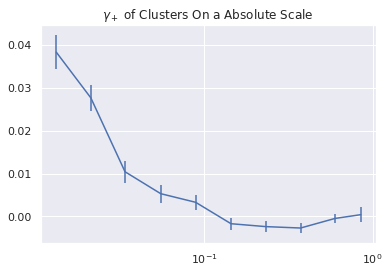

Aggregated xi:
[-27.4353 -43.3349 -25.8444 -21.761  -22.7732  18.7487  38.9824  59.4357
  11.2208  -3.3547]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -3099.0453  -6041.5111  -8395.6903 -11868.503  -16662.5161 -21515.1627
 -24144.0434 -21789.4878 -12501.6194  -1312.8811]
------------------------------------------------------------------------------
Aggregated npairs:
[  716.  1567.  2478.  4093.  6878. 11102. 16500. 22080. 24177.  7971.]
------------------------------------------------------------------------------
Mean xi:
[-0.0383 -0.0277 -0.0104 -0.0053 -0.0033  0.0017  0.0024  0.0027  0.0005
 -0.0004]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3283 -3.8555 -3.3881 -2.8997 -2.4226 -1.938  -1.4633 -0.9868 -0.5171
 -0.1647]
------------------------------------------------------------------------------


In [25]:
plt_w_error(mean_abs[1],-mean_abs[0],sig_abs,r"$\gamma_+$ of Clusters On a Absolute Scale ")
print_data(sum_abs,mean_abs)

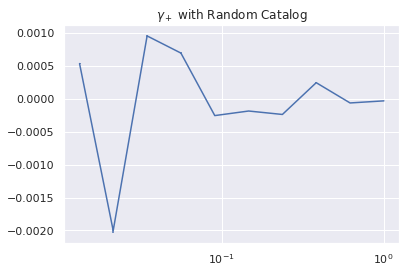

[ 5.3807e-04 -2.0032e-03  9.5860e-04  6.9755e-04 -2.5362e-04 -1.8407e-04
 -2.3639e-04  2.4706e-04 -6.1347e-05 -2.9438e-05]
[-8.3424e-06  3.1058e-05 -1.4862e-05 -1.0815e-05  3.9322e-06  2.8539e-06
  3.6650e-06 -3.8305e-06  9.5114e-07  4.5641e-07]


In [26]:
plt_w_error(r_meanlogr,-r_xi,r_sigma,r"$\gamma_+$ with Random Catalog")
print(-r_xi)
print(r_sigma)

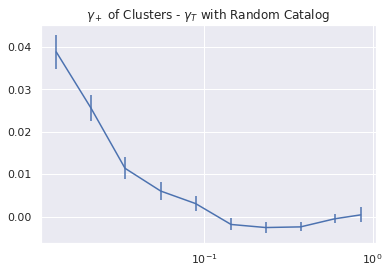

In [27]:
plt_w_error(mean_abs[1],-(mean_abs[0]+r_xi),np.hypot(r_sigma,sig_abs),r"$\gamma_+$ of Clusters - $\gamma_T$ with Random Catalog")

# Rel plots

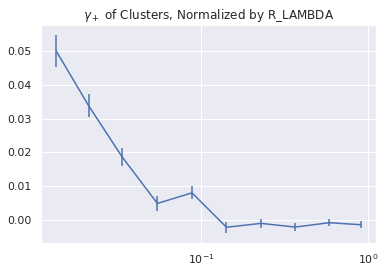

Aggregated xi:
[-19.8059 -36.333  -38.2116 -15.2512 -42.3117  19.5792  14.9155  42.4258
  21.624   29.6157]
------------------------------------------------------------------------------
Aggregated meanlogr:
[ -1703.66    -4141.2036  -6953.6873  -9195.9015 -12910.412  -17022.3822
 -20181.8071 -19444.8718 -12818.9093  -1970.8026]
------------------------------------------------------------------------------
Aggregated npairs:
[  396.  1074.  2049.  3164.  5316.  8720. 13671. 19361. 24085. 19835.]
------------------------------------------------------------------------------
Mean xi:
[-0.05   -0.0338 -0.0186 -0.0048 -0.008   0.0022  0.0011  0.0022  0.0009
  0.0015]
------------------------------------------------------------------------------
Mean meanlogr:
[-4.3022 -3.8559 -3.3937 -2.9064 -2.4286 -1.9521 -1.4762 -1.0043 -0.5322
 -0.0994]
------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [28]:
plt_w_error(mean_rel[1],-mean_rel[0],sig_rel,r"$\gamma_+$ of Clusters, Normalized by R_LAMBDA")
print_data(sum_rel,mean_rel)